In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Checkout the labels of the SST Data
data = pd.read_csv("drive/My Drive/Ceylon Surfers/Arugam Bay Mean Monthly SST(2020-24).csv")

In [17]:
print(data.describe())

               SST
count    60.000000
mean   2902.382579
std      83.024963
min    2703.322581
25%    2840.661290
50%    2902.936022
75%    2970.239516
max    3045.766667


In [18]:
print(data.head())

     Month          SST
0  2020-01  2814.193548
1  2020-02  2830.448276
2  2020-03  2890.548387
3  2020-04  2998.533333
4  2020-05  3021.129032


In [19]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
sst = data['SST'].astype(float).values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(sst)

Creating Sequences and Train-Test Split

In [20]:
window_size = 12
X = []
y = []
target_dates = data.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Building the LSTM Model

In [21]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 781ms/step - loss: 0.3506 - val_loss: 0.0641
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1635 - val_loss: 0.0168
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0770 - val_loss: 0.0266
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0692 - val_loss: 0.0244
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0738 - val_loss: 0.0227
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0661 - val_loss: 0.0195
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0706 - val_loss: 0.0206
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0733 - val_loss: 0.0268
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0781 - val_loss: 0.0251
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0774 - val_loss: 0.0193
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0773 - val_loss: 0.0158
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0738 - val_l

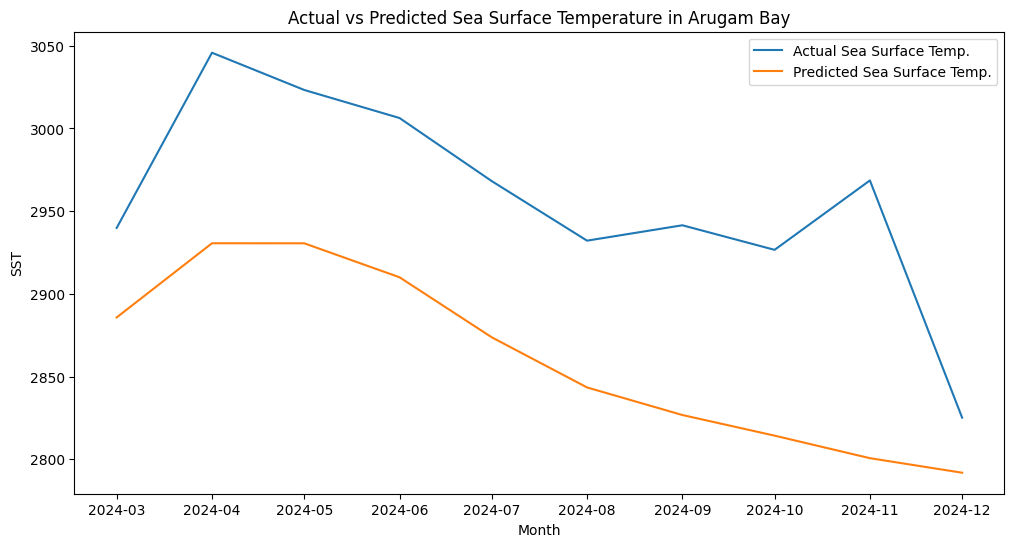

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Sea Surface Temp.')
plt.plot(dates_test, predictions, label='Predicted Sea Surface Temp.')
plt.title('Actual vs Predicted Sea Surface Temperature in Arugam Bay')
plt.xlabel('Month')
plt.ylabel('SST')
plt.legend()
plt.show()